## Analyse models checkpoints for NLL of positives in the test set

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import reinvent.models.reinvent.models.model as reinvent

In [2]:
%%bash
ls ../../data/test/

aggregators.npy
chembl.npy
fluc.csv
nluc.csv
redox.csv
thiol.csv


In [3]:
# get collected data for each different task
tasks = ["fluc", "nluc", "redox", "thiol"]
acquisition = ["random", "greedy", "epig", "greedyskill", "epigskill"]

In [35]:
# get the data
data = {i: {j: [] for j in acquisition} for i in tasks}

In [36]:
for i in range(1, 6):
    for j in tqdm(acquisition):
        for k in tasks:
            repeat = []
            for l in range(1, 11):
                df = pd.read_csv(f"../../FtF4/RUN_REINVENT/v{i}/{j}/{k}/selected_{l}.csv")
                repeat.append((df["interference"] >= 0.5).sum())
            data[k][j] += repeat

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
df = pd.DataFrame(data["thiol"])
df["Iteration"] = np.array([[i for i in range(0, 10)] for _ in range(5)]).ravel()

In [55]:
df_melted = pd.melt(df, id_vars="Iteration", var_name="Acquisition\nfunction", value_name="Positives")
palette = ["#808080", "#ee82ee", "#FFA500", "#0000ff", "#7741f7", "#805380"]

/tmp/ipykernel_1430553/803800918.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,


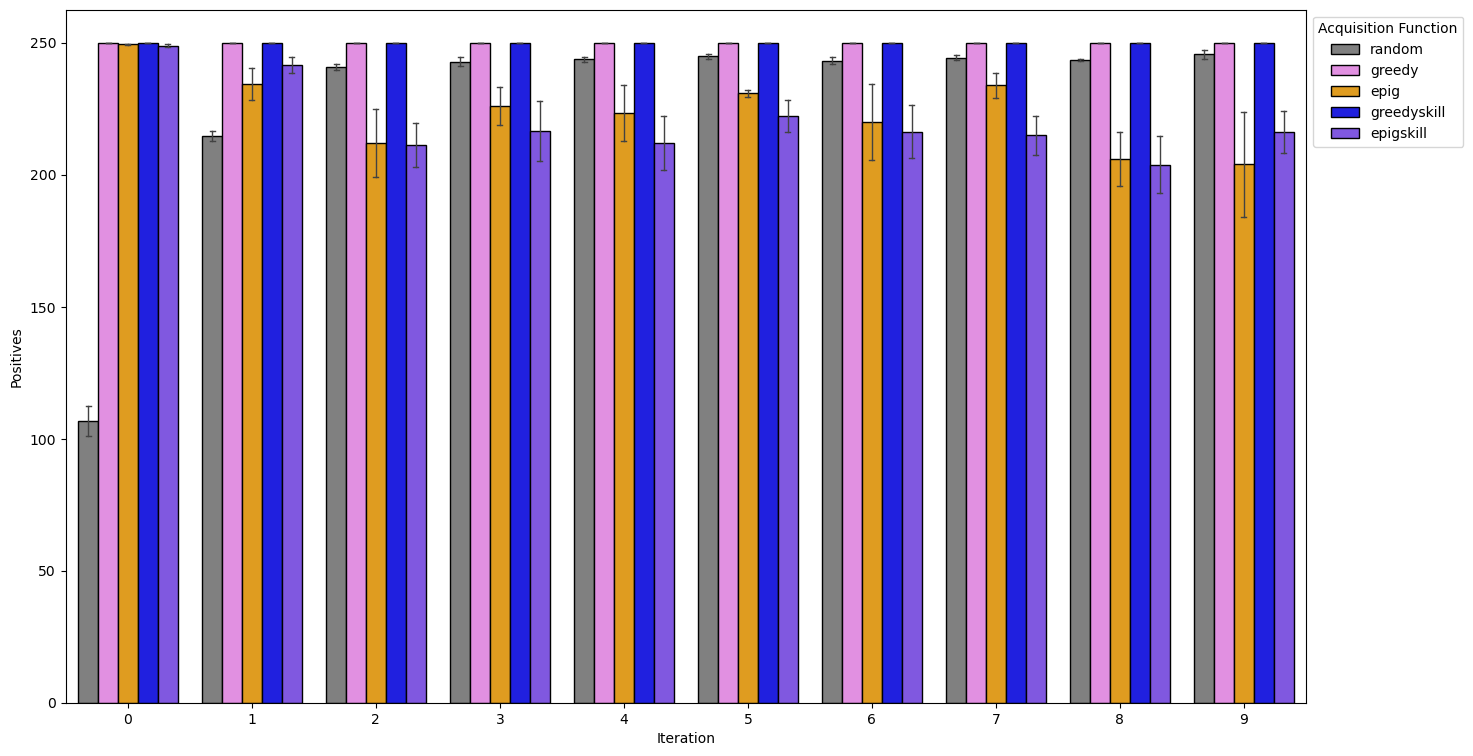

In [57]:
plt.figure(figsize=(16, 9))

sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,
             errorbar="se", err_kws={'linewidth': 1.0}, capsize=0.2, linewidth=1.0,  edgecolor="k")

# add horizontal line for the original model
# plt.axhline(y=teacher_mcc_mean + teacher_mcc_std, color='r', linestyle='--');

plt.legend(title='Acquisition Function', bbox_to_anchor=(1., 1), loc='upper left')

/tmp/ipykernel_1430553/1186252087.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,
/tmp/ipykernel_1430553/1186252087.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,
/tmp/ipykernel_1430553/1186252087.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,
/tmp/ipykernel_1430553/1186252087.py:8: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,


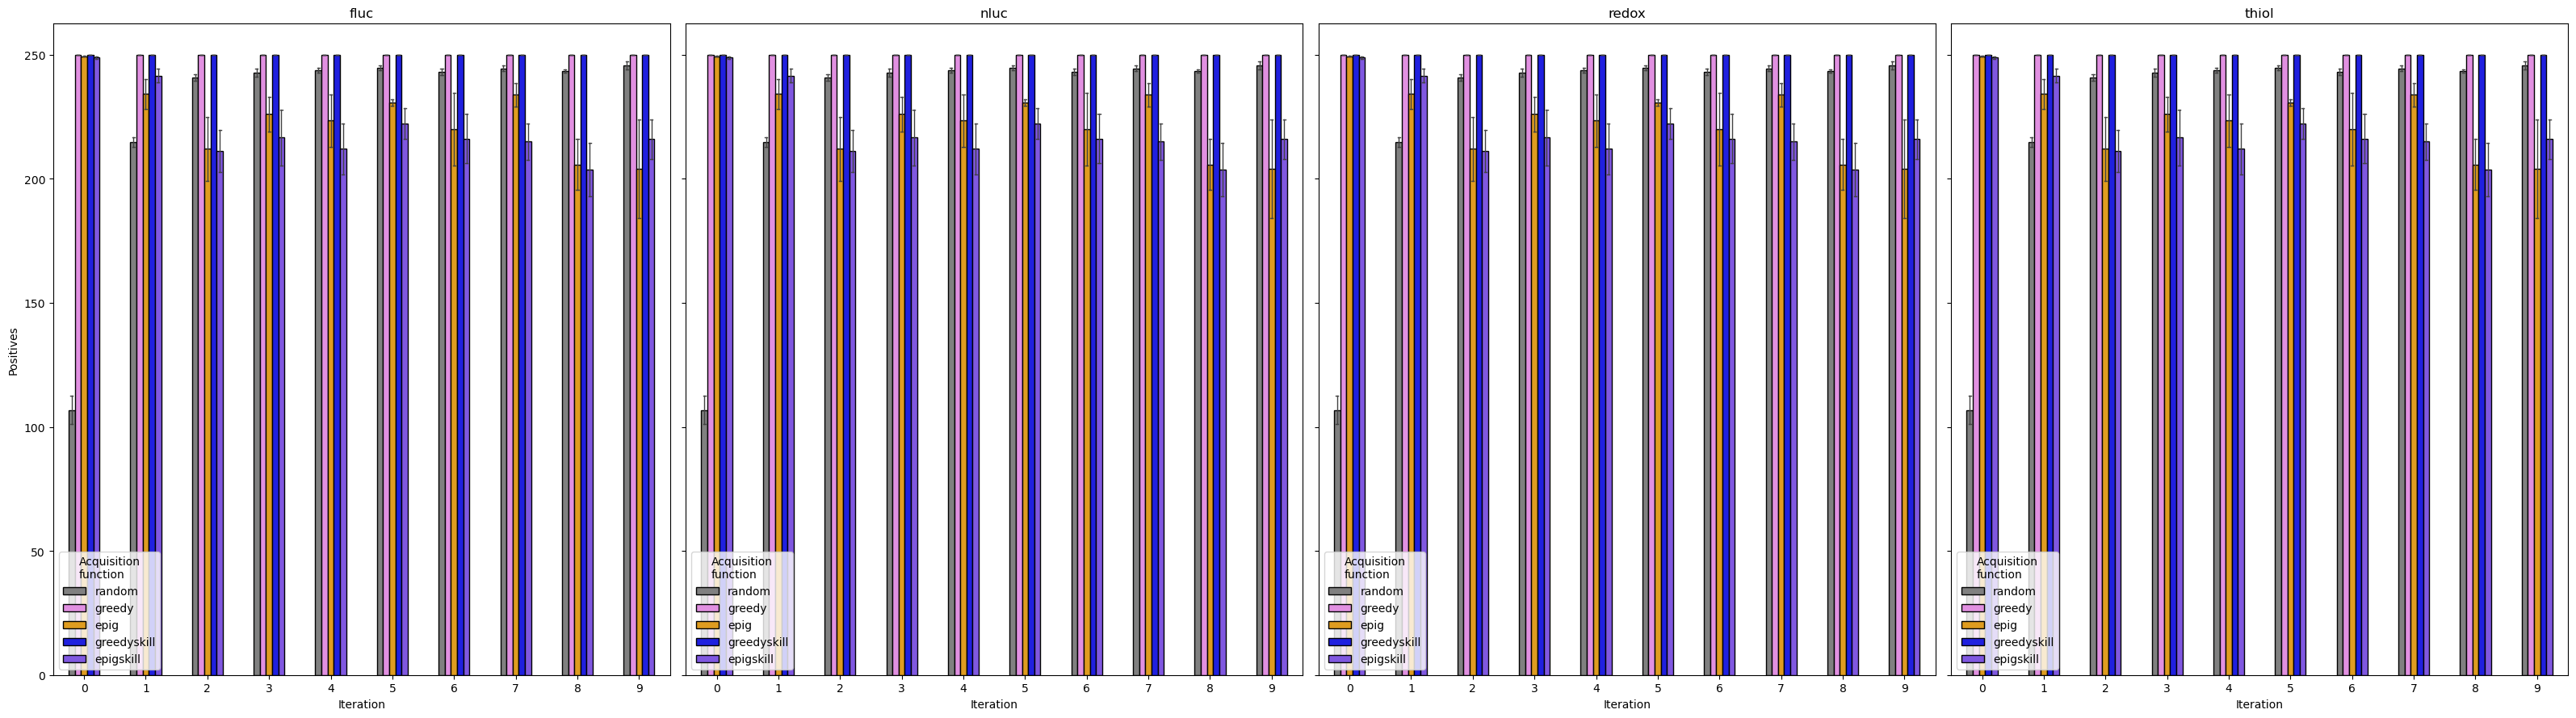

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(32, 9), sharey=True)
for idx, i in enumerate(tasks):
    df = pd.DataFrame(data["thiol"])
    df["Iteration"] = np.array([[i for i in range(0, 10)] for _ in range(5)]).ravel()
    df_melted = pd.melt(df, id_vars="Iteration", var_name="Acquisition\nfunction", value_name="Positives")
    palette = ["#808080", "#ee82ee", "#FFA500", "#0000ff", "#7741f7", "#805380"]

    sns.barplot(x="Iteration", y="Positives", hue="Acquisition\nfunction", data=df_melted, palette=palette,
                errorbar="se", width=0.5, err_kws={'linewidth': 1.0}, capsize=0.2, linewidth=1.0,  edgecolor="k", ax=ax[idx], legend=True)
    ax[idx].set_title(i)

plt.tight_layout()
plt.show()

#### Load test data

In [87]:
def preprocess(smiles):
    salt_remover = SaltRemover.SaltRemover()
    smiles = smiles.replace("@", "")
    smiles = smiles.replace("/", "")
    if "I" in smiles:
        return None
    mol = Chem.MolFromSmiles(smiles)
    mol = salt_remover.StripMol(mol)

    return Chem.MolToSmiles(mol)

In [88]:
test_data = pd.read_csv(f"../../data/test/{task}.csv")
# Collect positive and negative samples
test_positives = test_data[test_data["label"] == 1]["smiles"].values.tolist()
test_positives = [preprocess(smiles) for smiles in test_positives if preprocess(smiles) is not None]
test_negatives = test_data[test_data["label"] == 0]["smiles"].values.tolist()
test_negatives = [preprocess(smiles) for smiles in test_negatives if preprocess(smiles) is not None]

#### Compute NNL for positive and negative examples

In [89]:
def retrieve_chkpt(acquisition, task, version, iteration):
    params = torch.load(f"../../FtF4/RUN_REINVENT/versions.history/v.chkpt/v{version}/{acquisition}/{task}/chkpt/{task}_{iteration}.chkpt")
    model = reinvent.Model.create_from_dict(
        save_dict=params, mode="inference", device=torch.device("cpu")
    )

    return model

In [103]:
def compute_likelihood(model, smiles):
    likelihood = []
    for i in smiles:
        try:
            likelihood.append(model.likelihood_smiles([i]).detach().numpy())
        except:
            continue
    return np.array(likelihood)

In [104]:
likelihood_positives = {i: [] for i in ["random", "greedy", "epig", "epigskill", "greedyskill"]}
for i in ["random", "greedy", "epig", "epigskill", "greedyskill"]:
    for j in tqdm(range(1, 6)):
        for k in range(1, 11):
            model = retrieve_chkpt(i, task, j, k)
            likelihood_positives[i].append(compute_likelihood(model, test_positives).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [105]:
likelihood_positives = pd.DataFrame(likelihood_positives)

In [106]:
likelihood_positives.index = np.array([[i for i in range(0, 10)] for _ in range(5)]).ravel()

In [107]:
# Name index columns
likelihood_positives["Iteration"] = np.array([[i for i in range(1, 11)] for _ in range(5)]).ravel()

In [108]:
df_melted = pd.melt(likelihood_positives, id_vars="Iteration", var_name="Acquisition\nfunction", value_name="likelihood")

In [109]:
palette = ["#808080", "#ee82ee", "#FFA500", "#0000ff", "#7741f7", "#805380"]

/tmp/ipykernel_1386927/1981520874.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(x="Iteration", y="likelihood", hue="Acquisition\nfunction", data=df_melted, palette=palette)


Text(0, 0.5, 'Likelihood')

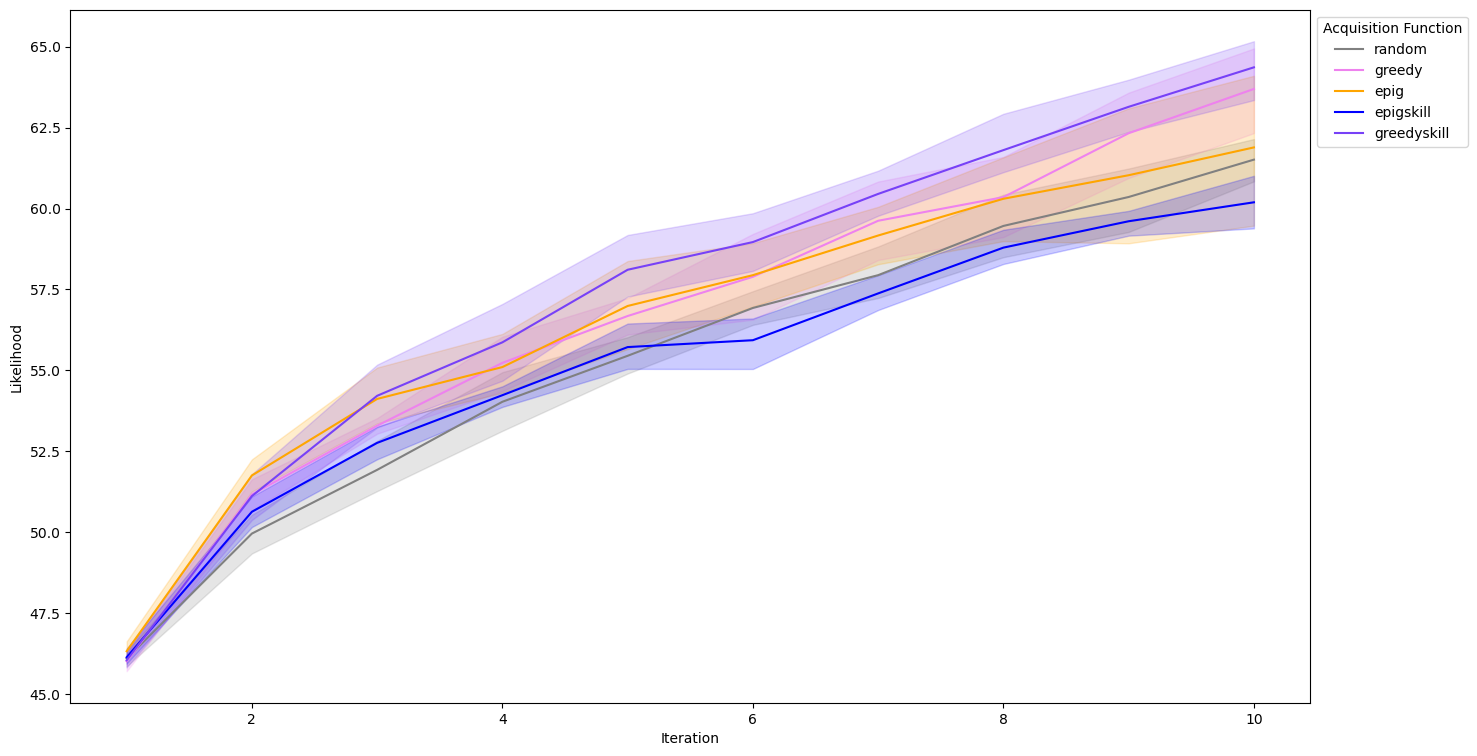

In [110]:
plt.figure(figsize=(16, 9))
sns.lineplot(x="Iteration", y="likelihood", hue="Acquisition\nfunction", data=df_melted, palette=palette)

plt.legend(title='Acquisition Function', bbox_to_anchor=(1., 1), loc='upper left')
plt.ylabel(f"Likelihood")
# set y-axis limits
#plt.ylim(0, 0.5)